## Flujo de Trabajo en NLP

<img src="./_src/PLN_Flujo_Trabajo.jpg" height="300"><br>

In [1]:
import pandas as pd
import nltk
import itertools
import re 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer



In [2]:
# Asegurarse de haber descargado los recursos necesarios
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [3]:
# Cargo la información de las reviews depuradas
df_reviews = pd.read_parquet('..\\datasets\\2. Depurado\\user_reviews_depurado.parquet')
#df_reviews = df_reviews.iloc[:1000]

# Cargo las Stopwords en Inglés

In [4]:
stopwords = nltk.corpus.stopwords.words('english') 

In [5]:
#stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

# Función para mapeo de tipo de palabra para Lematización

In [6]:
# Las etiquetas refieren al tipo de palabra. Vamos a definir una función para traducir estas etiquetas a los valores de POS que entiende 'wordnet_lemmatizer'.
def get_wordnet_pos(word):
    
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    print(tag)     
    return tag_dict.get(tag, wordnet.NOUN)

# TOKENIZACIÓN, EXPRESIONES REGULARES y LEMATIZCIÓN

In [7]:
# Las etiquetas refieren al tipo de palabra. Vamos a definir una función para traducir estas etiquetas a los valores de POS que entiende 'wordnet_lemmatizer'.
def get_wordnet_pos(word):
    
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)



def process_review(review):
    if pd.isna(review):
        return []  # Review vacío
    
    # Limpieza y procesamiento
    # Si la review no es nula
    
    # Eliminar todo lo que no sean letras y convertir a minúsculas
    review = re.sub("[^a-zA-Z]", " ", str(review)).lower()
    # Tokeniza la review depues de sacar las condiciones regulares que le pasamos
    tokenizer = RegexpTokenizer(r'\w+')
    review = tokenizer.tokenize(review)
    # Elimina las stopwords 
    review = [word for word in review if word not in stopwords]
    # Lematización
    review = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in review]
    
    return review


# Aplicar la función de procesamiento a cada reseña
df_reviews["processed_reviews"] = df_reviews["review"].apply(process_review)


# CORRO TextBlob

In [8]:
from textblob import TextBlob

In [9]:
# Función para clasificar el sentimiento
def classify_sentiment(review):
    # Unir la lista de palabras en una cadena de texto
    review_text = " ".join(review)

    if not review_text:
        return 'Neutro' # Si no hay review, asignar "Neutro"
    
    # Crear un objeto TextBlob
    blob = TextBlob(review_text)
    # Obtener el sentimiento
    polarity = blob.sentiment.polarity

    # Clasificación del sentimiento
    if polarity > 0:
        return 'Positivo'
    elif polarity < 0:
        return 'Negativo'
    else:
        return 'Neutro'

# Aplicar la función a la columna "review"
df_reviews['sentiment'] = df_reviews['processed_reviews'].apply(classify_sentiment)

# Aplicar el valor necesario
df_reviews['sentiment_value'] = df_reviews['sentiment'].map({'Negativo': '0', 'Neutro': '1', 'Positivo':'2'})

# Guardo el resultado para su uso posterior
df_reviews.to_parquet('..\\datasets\\3. Depurado y Reducido\\user_reviews_NLP.parquet', index=False)


In [10]:
df_reviews.head()

,user_id,user_url,item_id,posted,helpful,recommend,funny,review,processed_reviews,sentiment,sentiment_value
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1250,"Posted November 5, 2011.",No ratings yet,True,,Simple yet with great replayability. In my opi...,"[simple, yet, great, replayability, opinion, z...",Positivo,2
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,22200,"Posted July 15, 2011.",No ratings yet,True,,It's unique and worth a playthrough.,"[unique, worth, playthrough]",Positivo,2
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,43110,"Posted April 21, 2011.",No ratings yet,True,,Great atmosphere. The gunplay can be a bit chu...,"[great, atmosphere, gunplay, bit, chunky, time...",Positivo,2
3,js41637,http://steamcommunity.com/id/js41637,251610,"Posted June 24, 2014.",15 of 20 people (75%) found this review helpful,True,,I know what you think when you see this title ...,"[know, think, see, title, barbie, dreamhouse, ...",Negativo,0
4,js41637,http://steamcommunity.com/id/js41637,227300,"Posted September 8, 2013.",0 of 1 people (0%) found this review helpful,True,,For a simple (it's actually not all that simpl...,"[simple, actually, simple, truck, drive, simul...",Negativo,0


C:\Users\Hernán\AppData\Local\Temp\ipykernel_11056\3147148875.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Recomendación')


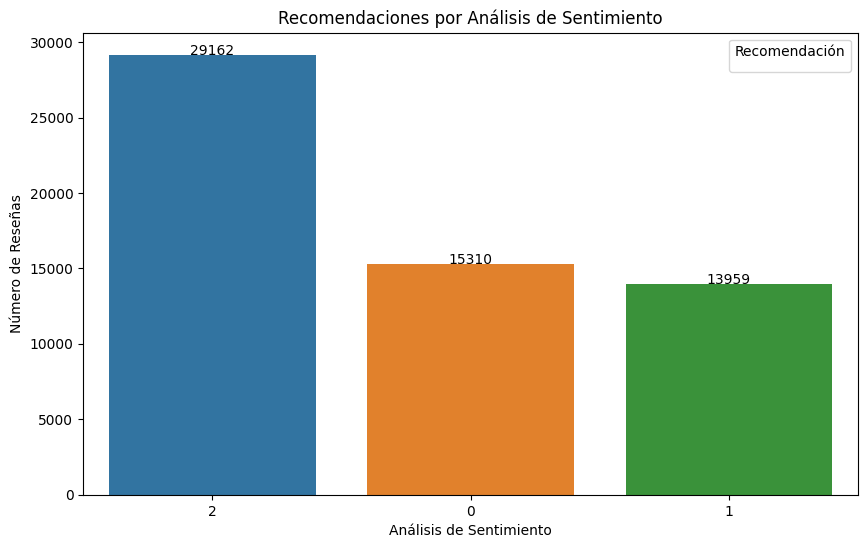

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Cargo la información de las reviews
df_reviews = pd.read_parquet('..\\datasets\\3. Depurado y Reducido\\user_reviews_NLP.parquet')
# Asegurarse de que las recomendaciones estén bien categorizadas
df_reviews['recommend'] = df_reviews['recommend'].map({True: 'Recommended', False: 'Not Recommended'})

# Crear la figura para el gráfico
plt.figure(figsize=(10, 6))

# Gráfico de conteo con 'sentiment' en el eje x y 'recommend' como el hue
ax = sns.countplot(data=df_reviews, x='sentiment_value', hue='sentiment_value')

# Añadir los valores a cada barra
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # Posición en X
        height + 1,  # Posición en Y
        int(height),  # Texto que mostrará (el valor)
        ha="center"  # Alineación horizontal
    )

# Título y etiquetas
plt.title('Recomendaciones por Análisis de Sentimiento')
plt.xlabel('Análisis de Sentimiento')
plt.ylabel('Número de Reseñas')
plt.legend(title='Recomendación')

# Mostrar el gráfico
plt.show()